# ARIMA на исторических

In [1]:
from alex.database import Database # вспомогательный класс для подключения к базе и работе с sql
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import pandas as pd
from decimal import Decimal
%matplotlib inline
from pprint import pprint

In [2]:
# stat packages
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf # функция расчёта автокорреляций
from statsmodels.graphics.tsaplots import plot_acf # визуализация автокорреляций
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

In [3]:
import seaborn as sns 
sns.set_style("whitegrid")
import altair as alt # пакет визуализации Altair
alt.renderers.enable('notebook')
alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

In [4]:
db = Database() # подключение к базе данных с учётными данными для Alex

## Загрузка истории

In [5]:
exchange = "binance"
pair = "ETH/USDT"
lag_seconds = 86400*7 #- 1 day

sql = f"select id, dt, price, amount, side from tvf_get_history_seconds_ago({lag_seconds}) order by dt, id"
history = db.query(sql)
# history = db.optimize_df(db.query(sql))

In [6]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1879499 entries, 0 to 1879498
Data columns (total 5 columns):
id        float64
dt        datetime64[ns]
price     float64
amount    float64
side      object
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 71.7+ MB


In [7]:
#history.index = pd.to_datetime(history['dt'])
#del history['dt']
history.set_index('dt', inplace=True)
history.side.astype('category')
history['volume'] = history.price * history.amount

### Фильтрация исходного набора

In [8]:
history_bak = history.copy()
#history = history[:int(len(history)/4)]
#history = history_bak.copy()

## Визуализация загруженных данных

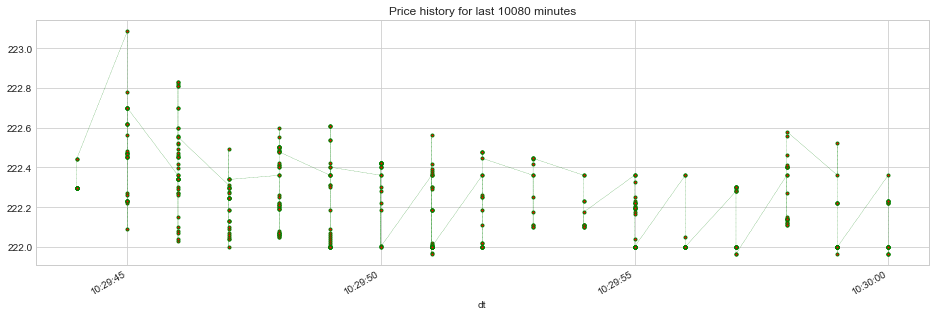

In [9]:
plt.rcParams['figure.figsize'] = [16, 5]
history['price'][-500:].plot(grid=True, marker='.', color='green', linestyle='--', 
                              linewidth=0.25, markerfacecolor='r')
plt.title(f"Price history for last {int(lag_seconds/60)} minutes")
plt.show()

## Мин, макс, среднее, медиана, стд.отклонение

In [10]:
h = history.describe()
mean = h.loc['mean', 'volume']
std = h.loc['std', 'volume']
median = h.loc['50%', 'volume']
low = h.loc['min', 'volume']
high= h.loc['max', 'volume']
print(f"среднее объёма = ${mean:.2f}\n"
      f"медиана объёма = ${median:.2f}\n"
      f"стандартное отклонение объёма = {std:.2f}\n"
      f"минимум объёма = ${low:.6f}\n"
      f"максимум объёма = ${high:.2f}")

среднее объёма = $447.75
медиана объёма = $53.93
стандартное отклонение объёма = 2509.19
минимум объёма = $0.000002
максимум объёма = $925504.71


In [11]:
h = history.describe()
mean = h.loc['mean', 'price']
std = h.loc['std', 'price']
median = h.loc['50%', 'price']
low = h.loc['min', 'price']
high= h.loc['max', 'price']
print(f"среднее цены = ${mean:.2f}\n"
      f"медиана цены = ${median:.2f}\n"
      f"стандартное отклонение цены = {std:.2f}\n"
      f"минимум цены = ${low:.6f}\n"
      f"максимум цены = ${high:.2f}")

среднее цены = $210.71
медиана цены = $202.97
стандартное отклонение цены = 13.58
минимум цены = $185.000000
максимум цены = $240.00


## Автокорреляция

In [12]:
def plot_price(x):
    plt.rcParams['figure.figsize'] = [16, 3]
    plt.plot(x, marker='.', color='gray', linestyle='--', linewidth=1, markerfacecolor='r')
    plt.show()

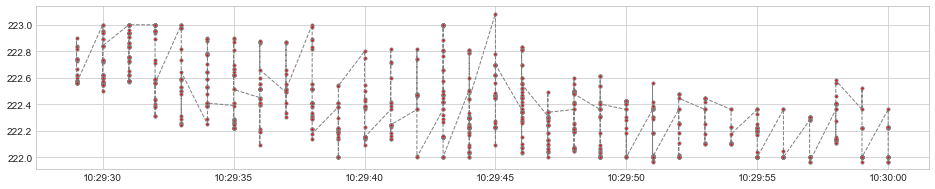

In [13]:
plot_price(history.price[-1000:])

Справочно: очень высокая автокорреляция соседних абсолютных значений цены

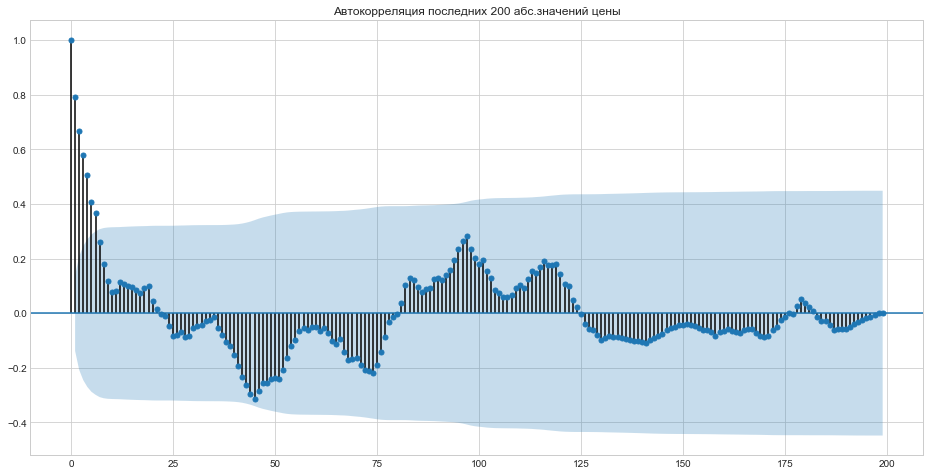

In [14]:
plt.rcParams['figure.figsize'] = [16, 8]
_ = plot_acf(history.price[-200:], title="Автокорреляция последних 200 абс.значений цены", alpha=0.05)

<b>Доверительный интервал</b> в 95% [1 - alpha] обозначен голубым конусом. Значения корреляций ВНЕ этого конуса показывают, что это не просто статистический выброс.<br/><br/>
Корелограмма медленно убывает по синусоиде, что косвенно указывает на нестационарность ряда

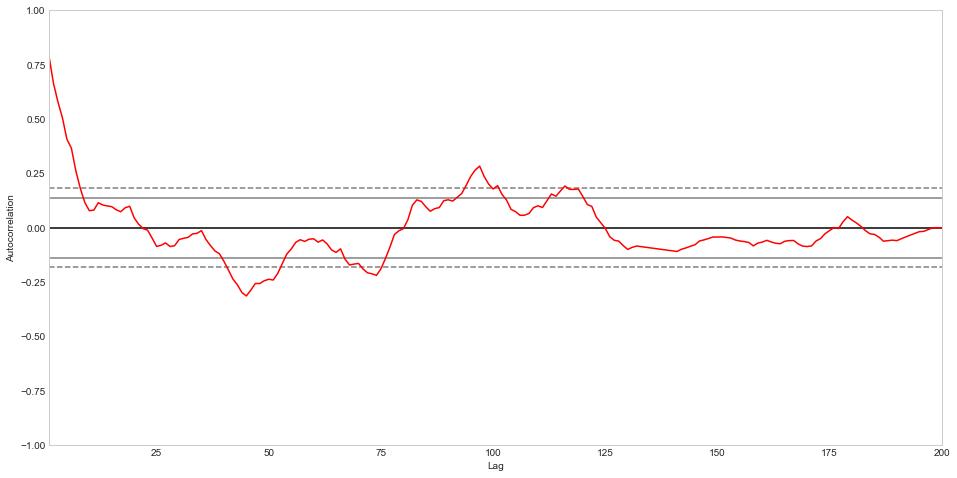

In [15]:
# второй вариант, используется встроенный в pandas autocorrelation_plot
plt.rcParams['figure.figsize'] = [16, 8]
autocorrelation_plot(history.price[-200:], color='r')
plt.show()

## Конвертация в OHLC

In [16]:
interval = 1 # minutes
df = history[['price', 'amount']].resample(str(interval)+'min').ohlc()

In [17]:
df.head()

price                                      \
                           open        high         low       close   
dt                                                                    
2018-10-08 10:30:00  224.839996  224.929993  224.714600  224.899994   
2018-10-08 10:31:00  224.889008  225.000000  224.400101  224.899994   
2018-10-08 10:32:00  224.899994  224.970001  224.824493  224.899902   
2018-10-08 10:33:00  224.899902  224.990005  224.806000  224.814499   
2018-10-08 10:34:00  224.949997  225.000000  224.559998  224.830795   

                        amount                                  
                          open        high       low     close  
dt                                                              
2018-10-08 10:30:00   0.000800  100.587555  0.000010  0.400000  
2018-10-08 10:31:00   0.007000    9.669990  0.000030  0.029031  
2018-10-08 10:32:00  12.511923   32.162819  0.001800  0.050000  
2018-10-08 10:33:00   0.078692   11.138400  0.000185  0.006000  
2018-10-08 10:34:00   0.603390   14.772850  0.002000  0.007000

In [18]:
df.shape

(10081, 8)

In [19]:
autocorrelation = df.price.close.autocorr(lag=1)
confidence = 1.96 / np.sqrt(len(df))
print(f"Автокорреляция по {interval}-минутным интервалам = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция по 1-минутным интервалам = 99.98%
Приблизительный доверительный интервал = +/- 0.0195


In [20]:
autocorrelation = df.price.close.pct_change().autocorr()
confidence = 1.96 / np.sqrt(len(df))
print(f"Автокорреляция по {interval}-минутным интервалам изменения по {interval}-мин интервалу = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция по 1-минутным интервалам изменения по 1-мин интервалу = 13.37%
Приблизительный доверительный интервал = +/- 0.0195


## Сезонность (разные лаги)

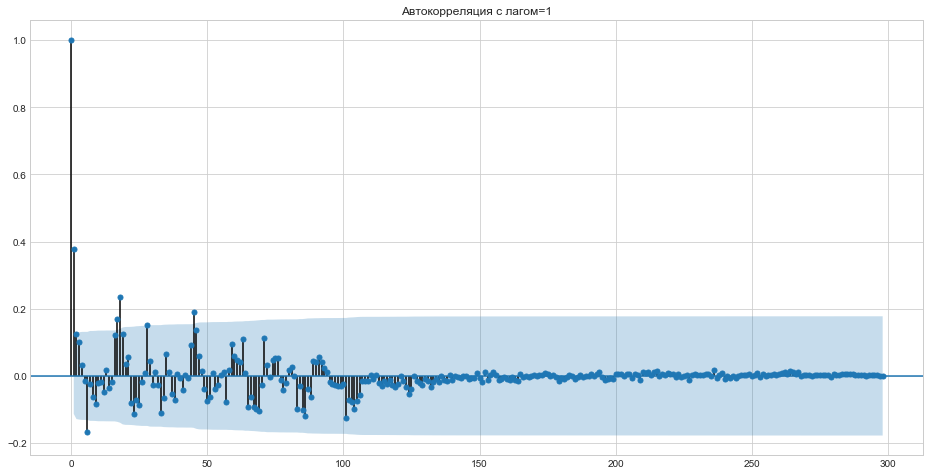

In [21]:
lag = 1
#df_lag = df.tail(300).price.close.pct_change().diff(lag).dropna()
df_lag = df.tail(300).price.close.diff(lag).dropna()
plt.rcParams['figure.figsize'] = [16, 8]
plot_acf(df_lag, title=f"Автокорреляция с лагом={lag}")
plt.show()


## ARIMA

In [22]:
# исходный набор, на котором тестируем ARIMA
df.price.tail()

,open,high,low,close
dt,,,,
2018-10-15 10:26:00,226.449997,227.176178,225.000000,225.625900
2018-10-15 10:27:00,225.300003,226.305222,215.995636,225.500000
2018-10-15 10:28:00,225.865387,226.415985,223.892197,224.117599
2018-10-15 10:29:00,224.500000,224.584793,221.964294,222.000000
2018-10-15 10:30:00,222.360001,222.360001,221.964294,222.000000


In [23]:
# Примерно 10000 строк, минутная разбивка
df.price.close.describe()

count    10078.000000
mean       211.269735
std         13.784695
min        189.060593
25%        199.897400
50%        202.301453
75%        226.879101
max        237.974106
Name: close, dtype: float64

In [24]:
# train/test split

starting = int(1440*3.8/interval)
split_point = int(1440*5/interval) # 3 days
ending = int(1440*6/interval)

train = df.fillna(method='ffill').iloc[starting:split_point,:] #head(split_point)
test = df.fillna(method='ffill').iloc[split_point:ending,:]
df_pct = df.price.close.iloc[starting:ending].diff().dropna(how='all')

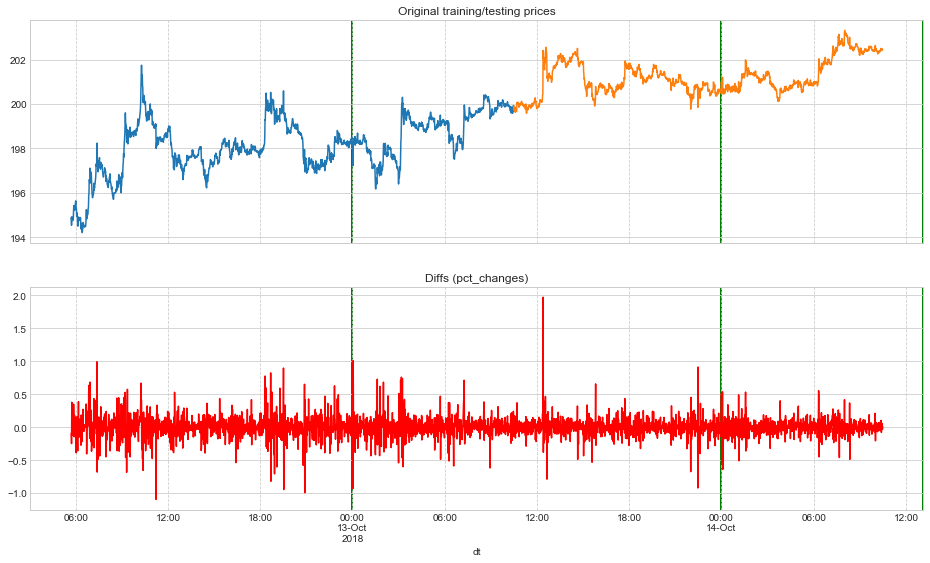

In [25]:
# xticks = pd.date_range(start=train.index.min(), end=train.index.max(), freq='15min')
days = dates.DayLocator()
hours = dates.HourLocator()
dfmt = dates.DateFormatter('%H:%M')

plt.rcParams['figure.figsize'] = [16, 9]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
ax0, ax1 = axes

ax0.grid(True, which='minor', linestyle='--')
ax0.grid(True, which='major', axis='x', color='g', linewidth=2)
ax1.grid(True, which='major', axis='x', color='g', linewidth=2)
ax1.xaxis.set_major_locator(days)
ax1.xaxis.set_minor_formatter(dfmt)
ax1.xaxis.set_minor_locator(hours)
ax1.grid(True, which='minor', axis='x', linestyle='--')

train.price.close.plot(ax=ax0, title="Original training/testing prices")
test.price.close.plot(ax=ax0)
df_pct.plot(ax=ax1, color='r', title="Diffs (pct_changes)")
plt.show()

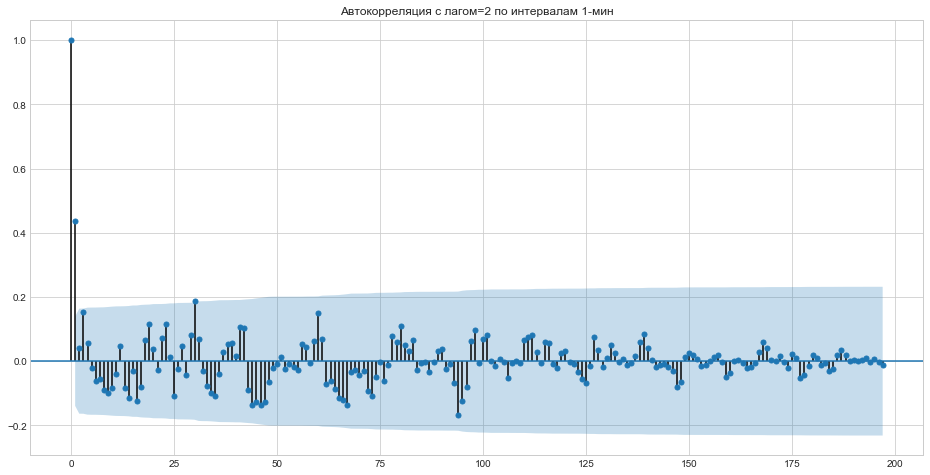

In [26]:
lag = 2

df_lag = train.price.close.head(200).diff(lag).dropna()
plt.rcParams['figure.figsize'] = [16, 8]
plot_acf(df_lag, title=f"Автокорреляция с лагом={lag} по интервалам {interval}-мин")
plt.show()

## SARIMAX

In [27]:
exog = sm.add_constant(train.price.close) #[-1:] + test.price.close[0:])

In [47]:
# ARIMA model init
p,d,q = 1,1,1
#model = ARMA(train.price.close, order=(p, q))
#model = ARIMA(train.price.close, order=(p,d,q))
model = SARIMAX(train.price.close, order=(p,d,q), trend='t', 
                seasonal_order=(0,1,1,12), mle_regression=True,
                enforce_stationarity=True, enforce_invertibility=False)

In [48]:
result = model.fit(disp=False)

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [49]:
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                 1728
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 291.490
Date:                            Mon, 15 Oct 2018   AIC                           -572.980
Time:                                    10:37:36   BIC                           -545.745
Sample:                                10-12-2018   HQIC                          -562.902
                                     - 10-13-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -9.606e-08   2.28e-06     -0.042      0.966   -4.57e-06    4.38e-06
ar.L1         -0.1061      0.342   

In [50]:
start = pd.to_datetime(train.index[0]).strftime('%Y-%m-%d %H:%M:%S')
end = pd.to_datetime(train.index[-1]).strftime('%Y-%m-%d %H:%M:%S')
start, end

('2018-10-12 05:42:00', '2018-10-13 10:29:00')

In [51]:
forecast0 = result.forecast()[0]
fact_price = test.price.close[0]
error = (forecast0/fact_price-1)*100
print(f"Next {interval}-min forecast: {forecast0}, actual: {fact_price}, error: {error:.2f}%")

Next 1-min forecast: 199.78592355241153, actual: 199.7375030517578, error: 0.02%


In [52]:
# вычисляем предсказания - вычисленная линейная компонента
predictions = result.predict(start=d, end=len(train)+len(test)) #, typ='levels')
predict = result.get_prediction(start=len(train), end=len(train)+len(test))
#predictions[end:].head(5)
predict.predicted_mean.tail(5)

2018-10-14 10:26:00    179.628350
2018-10-14 10:27:00    179.607202
2018-10-14 10:28:00    179.625189
2018-10-14 10:29:00    179.579884
2018-10-14 10:30:00    179.542592
Freq: T, dtype: float64

In [53]:
# вычисляем out-of-sample прогноз
forecasts = result.forecast(steps=len(test))

In [54]:
forecast = pd.DataFrame(list(zip(test.price.close.index[:len(forecasts)], forecasts)), 
             columns=['dt', 'forecast']).set_index('dt')['forecast']
forecast.head()

dt
2018-10-13 10:30:00    199.785924
2018-10-13 10:31:00    199.719411
2018-10-13 10:32:00    199.724970
2018-10-13 10:33:00    199.760947
2018-10-13 10:34:00    199.757057
Name: forecast, dtype: float64

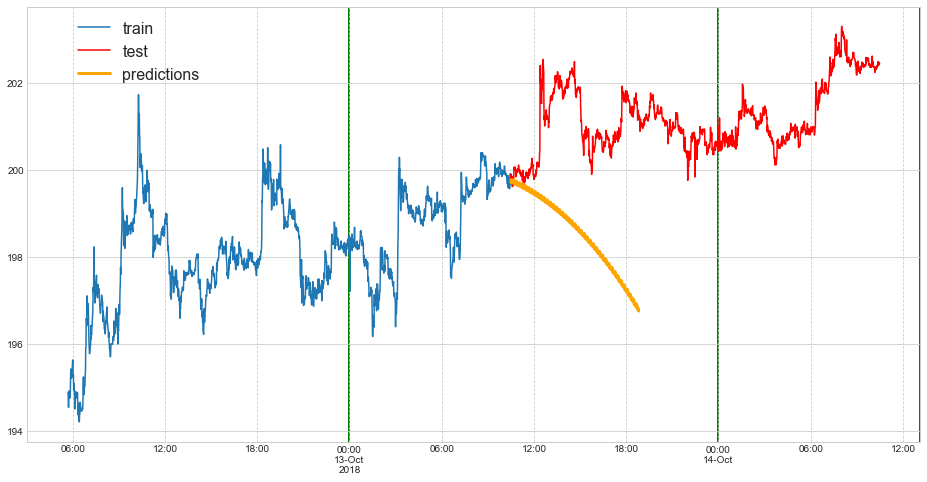

In [55]:
fig, ax = plt.subplots()
train.price.close.plot(ax=ax)
test.price.close.plot(color='r', ax=ax)
ax.grid(True, which='minor', linestyle='--')
ax.grid(True, which='major', axis='x', color='g', linewidth=2)
#fig = result.plot_predict(start=end, end=len(train)+len(test), dynamic=True, plot_insample=False, ax=ax)
#predictions[end:].head(500).plot(color='g', linewidth=2)
#forecast.plot(color='orange', linewidth=2, ax=ax)
predict.predicted_mean.head(500).plot(color='orange', linewidth=3)
ax.legend(['train', 'test', 'predictions', 'confidence'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))
ax.set(xlabel='')
plt.show()

In [56]:
predict.predicted_mean.tail(10)

2018-10-14 10:21:00    179.778378
2018-10-14 10:22:00    179.749146
2018-10-14 10:23:00    179.690245
2018-10-14 10:24:00    179.679518
2018-10-14 10:25:00    179.631166
2018-10-14 10:26:00    179.628350
2018-10-14 10:27:00    179.607202
2018-10-14 10:28:00    179.625189
2018-10-14 10:29:00    179.579884
2018-10-14 10:30:00    179.542592
Freq: T, dtype: float64

In [57]:
train.tail(10)

price                                       amount  \
                           open        high         low       close     open   
dt                                                                             
2018-10-13 10:20:00  199.527603  199.725403  199.525208  199.595200  0.00720   
2018-10-13 10:21:00  199.595200  199.812500  199.584000  199.812500  0.00720   
2018-10-13 10:22:00  199.750000  199.819199  199.520004  199.819199  0.50000   
2018-10-13 10:23:00  199.655106  199.839996  199.589996  199.617905  0.00720   
2018-10-13 10:24:00  199.617905  199.809998  199.617905  199.684097  0.00720   
2018-10-13 10:25:00  199.684097  199.750000  199.565002  199.579697  0.00720   
2018-10-13 10:26:00  199.574997  199.759995  199.529495  199.759995  0.00720   
2018-10-13 10:27:00  199.690002  199.725800  199.522598  199.686493  0.09732   
2018-10-13 10:28:00  199.685303  199.954102  199.685303  199.926498  0.00720   
2018-10-13 10:29:00  199.839996  199.949295  199.745193  199.785095  1.70199   

                                                    
                          high       low     close  
dt                                                  
2018-10-13 10:20:00   6.119500  0.000078  0.007200  
2018-10-13 10:21:00  17.057301  0.000652  0.905045  
2018-10-13 10:22:00  55.906826  0.000200  1.043187  
2018-10-13 10:23:00  11.940518  0.007200  0.007200  
2018-10-13 10:24:00   3.161730  0.000400  0.007200  
2018-10-13 10:25:00  72.835587  0.000065  0.007200  
2018-10-13 10:26:00   9.487200  0.000210  1.600000  
2018-10-13 10:27:00  12.524910  0.000060  0.029451  
2018-10-13 10:28:00  29.605648  0.000050  6.958064  
2018-10-13 10:29:00  18.361300  0.000010  0.031420

## Pyramid ARIMA

In [58]:
import pyramid
print(f"pyramid version: {pyramid.__version__}")

pyramid version: 0.8.1


In [59]:
from pyramid.arima import ARIMA as pARIMA

In [90]:
fit = pARIMA(order=(1,1,1), seasonal_order=(1,1,1,12)).fit(y=train.price.close)

In [91]:
print(fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 478.486
Date:                            Mon, 15 Oct 2018   AIC                           -944.971
Time:                                    11:41:32   BIC                           -912.288
Sample:                                         0   HQIC                          -932.877
                                           - 1728                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.375e-05      0.000     -0.413      0.680      -0.000       0.000
ar.L1         -0.1898      0.175   

Интересно, что pyramid, видимо, частично базируется на коде statmodels - строится модель SARIMAX

In [92]:
# делаем датафрейм с out-of-sample предсказаниями sarimax:
predictions = pd.DataFrame(list(zip(test.price.close.index[:len(forecasts)], 
                                 fit.predict(n_periods=len(test)))), 
             columns=['dt', 'forecast']).set_index('dt')['forecast']

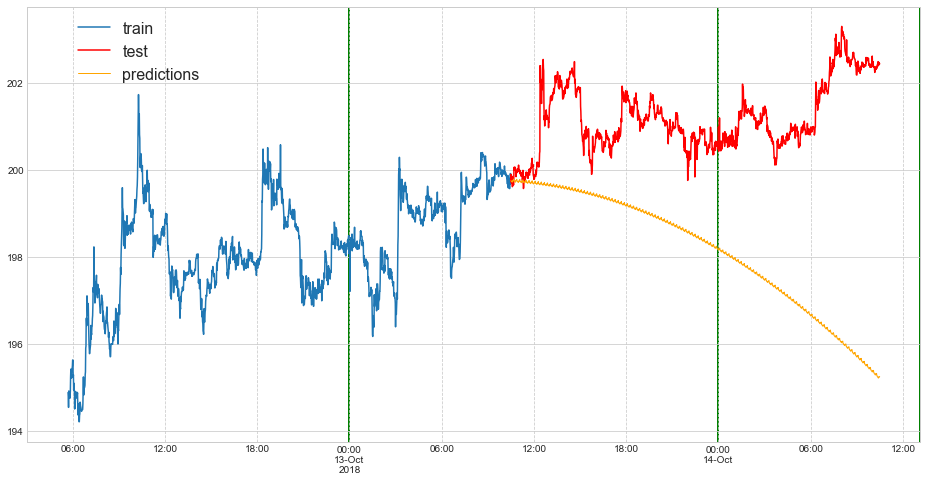

In [93]:
fig, ax = plt.subplots()
train.price.close.plot(ax=ax)
test.price.close.plot(color='r', ax=ax)
ax.grid(True, which='minor', linestyle='--')
ax.grid(True, which='major', axis='x', color='g', linewidth=2)
#fig = result.plot_predict(start=end, end=len(train)+len(test), dynamic=True, plot_insample=False, ax=ax)
#predictions[end:].head(500).plot(color='g', linewidth=2)
#forecast.plot(color='orange', linewidth=2, ax=ax)
#predict.predicted_mean.head(500).plot(color='orange', linewidth=3)
predictions.plot(color='orange', linewidth=1, ax=ax)
ax.legend(['train', 'test', 'predictions', 'confidence'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))
ax.set(xlabel='')
plt.show()

### Auto-ARMIA

In [46]:
from pyramid.arima import auto_arima

In [62]:
stepwise_fit = auto_arima(train.price.close, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-945.789, BIC=-918.553, Fit time=9.225 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=146.920, BIC=157.814, Fit time=0.259 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-346.567, BIC=-324.778, Fit time=1.732 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-946.936, BIC=-925.148, Fit time=4.445 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-946.361, BIC=-919.125, Fit time=6.177 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=130.974, BIC=147.316, Fit time=0.282 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-946.126, BIC=-918.890, Fit time=12.074 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-944.627, BIC=-911.944, Fit time=15.477 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-927.074, BIC=-910.732, Fit time=2.572 seconds
Fit ARIMA: order=(0, 1, 2) sea

In [63]:
print(stepwise_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1728
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                 482.801
Date:                            Mon, 15 Oct 2018   AIC                           -951.603
Time:                                    11:28:30   BIC                           -913.473
Sample:                                         0   HQIC                          -937.493
                                           - 1728                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.663e-05   6.61e-05     -0.403      0.687      -0.000       0.000
ar.L1          0.9329      0.101   

Pyramid нашла лучшие параметры для SARIMAX для (p, d, q)x(сезонность) = (2, 1, 2)x(0, 1, 1, 12)

In [87]:
# делаем датафрейм с out-of-sample предсказаниями sarimax:
auto_arima =  pd.DataFrame(list(zip(test.price.close.index[:len(forecasts)], 
                                 stepwise_fit.predict(n_periods=len(test)))), 
             columns=['dt', 'forecast']).set_index('dt')['forecast']

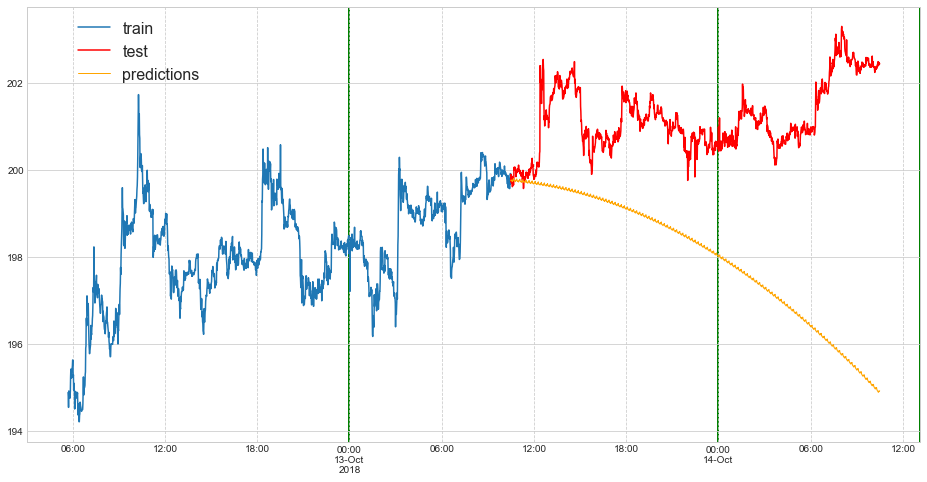

In [97]:
fig, ax = plt.subplots()

train.price.close.plot(ax=ax)
test.price.close.plot(color='r', ax=ax)

ax.grid(True, which='minor', linestyle='--')
ax.grid(True, which='major', axis='x', color='g', linewidth=2)
auto_arima.plot(color='orange', linewidth=1, ax=ax)

ax.legend(['train', 'test', 'predictions', 'confidence'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))
ax.set(xlabel='')
plt.show()

### Использование внутреннего функционала Pyramid для вывода

In [95]:
from bokeh.plotting import figure, show, output_notebook
# init bokeh
output_notebook()

Loading BokehJS ...

In [96]:
def plot_arima(truth, forecasts, title="ARIMA", xaxis_label='Time',
               yaxis_label='Value', c1='#A6CEE3', c2='#B2DF8A', 
               forecast_start=None, **kwargs):
    
    # make truth and forecasts into pandas series
    n_truth = truth.shape[0]
    n_forecasts = forecasts.shape[0]
    
    # always plot truth the same
    truth = pd.Series(truth, index=np.arange(truth.shape[0]))
    
    # if no defined forecast start, start at the end
    if forecast_start is None:
        idx = np.arange(n_truth, n_truth + n_forecasts)
    else:
        idx = np.arange(forecast_start, n_forecasts)
    forecasts = pd.Series(forecasts, index=idx)
    
    # set up the plot
    p = figure(title=title, plot_height=400, **kwargs)
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = xaxis_label
    p.yaxis.axis_label = yaxis_label
    
    # add the lines
    p.line(truth.index, truth.values, color=c1, legend='Observed')
    p.line(forecasts.index, forecasts.values, color=c2, legend='Forecasted')
    
    return p

In [103]:
show(plot_arima(train.price.close.values, stepwise_fit.predict(n_periods=100)))